Overall intended workflow for Abidjan flood detection. Based on process established by Huang et al. (2015)
    - Import DG image downloaded from GBDX platform
    - Convert geotiff files to numpy array via rasterio
    - Scale to surface reflectance values (divide by 10,000)
    - Define individual bands for later calculations
    - Calculate indices (NDVI, multiple versions of NDWI) and dark parameter
    - Threshold and plot based on Cloud to Street algorithm
    - Calculate MSI 
    - Threshold and plot NDVI, NDWI and MSI
    - Compare output to Cloud-to-Street results
    - Segment final image 
    - Identify characteristics of objects (area, shape, density, length:width ratio, homogeneity)

**References**
Huang, X., Xie, C., Fang, X., Zhang, L. Combining Pixel-and Object-Based Machine Learning for Identification of Water-Body Types from Urban High-Resolution Remote-Sensing Imagery. IEEE J. Sel. Top. Appl. Earth Obs. Remote Sens. 2015, 8, 2097–2110.

Cloud to Street. Urban Flood Mapping Using Very-High Resolution Satellite Imagery. Available at: https://abidjan.cloudtostreet.info/info

This notebook calculates and plots NDVI and three different formulations of NDWI as defined within the notebook. Cloud and flood plots are produced based on the algorithm provided by Cloud to Street:

**Final algorithm from Cloud-to-Street for Abidjan image:**

**Clouds:**

C ≥ 0.25 and RE  ≥ 0.25

**Flood:**

(NDWI1 ≥ -0.35, DARK ≤ 5, C ≤ 1, and R ≤ 0.85 ) or

(NDWI2 ≥ 0.03, DARK ≤ 5.8, C ≤ 1)

In [1]:
%matplotlib inline

In [2]:
# Import necessary packages
import os
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import rasterio as rio
from rasterio.mask import mask
import earthpy as et
import earthpy.spatial as es

In [3]:
# Set working directory
os.chdir(os.path.join(et.io.HOME, 'earth-analytics','spring-2019', 'ndwi-project'))
os.environ["PROJ_LIB"] = r"C:\Users\katy\Anaconda3\envs\earth-analytics-python\Library\share"

# Establish consistent font sizes for plots
plt.rcParams.update({'font.size': 15})

In [4]:
band_path = "dg-data/abidjan-crop-20160617/"
all_dg_bands = glob(band_path+"*band_*")
all_dg_bands.sort()
# all_dg_bands

In [6]:
# Create raster stack
all_bands_path = "dg-data/outputs/all_bands.tif"
all_bands, all_bands_meta = es.stack_raster_tifs(all_dg_bands,
                                             all_bands_path)

In [7]:
# Open raster stack
with rio.open(all_bands_path) as src:
    all_bands_stack = src.read()  

In [8]:
# Scale raster stack to surface reflectance values (should be between 0 and 1)
all_bands_scaled = all_bands_stack/10000

In [9]:
# Commented out due to memory issues

# Plot histogram to explore scaled value distribution 
# fig,ax = plt.subplots()
# plt.hist(all_bands_scaled.ravel(), bins='auto');

In [ ]:
# Check for max scaled values 
# print(all_bands_scaled[7].max(), all_bands_stack[7].max())

In [ ]:
# Commented out due to memory issues

#Plot one band to take quick look at image
# fig,ax = plt.subplots()
# plt.imshow(all_bands_scaled[0])

In [10]:
# Read in scaled bands
coastal_band = all_bands_scaled[0]
blue_band = all_bands_scaled[1]
green_band = all_bands_scaled[2]
yellow_band = all_bands_scaled[3]
red_band = all_bands_scaled[4]
rededge_band = all_bands_scaled[5]
nearir1_band = all_bands_scaled[6]
nearir2_band = all_bands_scaled[7]

In [11]:
# Calculate NDWI values
# NDWI0 = (G-NIR1)/(G+NIR1) - McFeeters (1996) 
# NDWI1 = (C - NIR2)/(C + NIR2)
# NDWI2 = (Y - NIR2) / (Y + NIR2); DARK = RE+NIR1+NIR2
ndwi0 = es.normalized_diff(b1=nearir1_band, b2=green_band)  
ndwi1 = es.normalized_diff(b1=nearir2_band, b2=coastal_band)
ndwi2 = es.normalized_diff(b1=nearir2_band, b2= yellow_band)

# ndwi0 = (green_band-nearir1_band)/(green_band+nearir1_band)
# ndwi1 = (coastal_band-nearir2_band)/(coastal_band+nearir2_band)
# ndwi2 = (yellow_band-nearir2_band)/(yellow_band+nearir2_band)

In [14]:
# Compare mean NDWI values 
mean_ndwi0 = np.nanmean(ndwi0)
mean_ndwi1 = np.nanmean(ndwi1)
mean_ndwi2 = np.nanmean(ndwi2)

print("NDWI0:",mean_ndwi0, "NDWI1:", mean_ndwi1, "NDWI2:", mean_ndwi2)

NDWI0: -0.08904313 NDWI1: -0.09009852 NDWI2: -0.027476316


In [16]:
# Calculate DARK parameter
dark = (rededge_band + nearir1_band + nearir2_band)

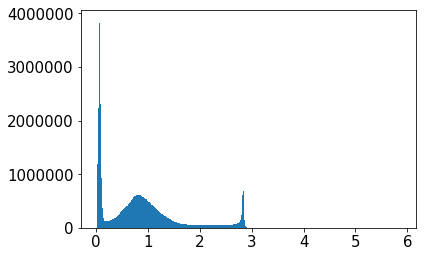

In [29]:
# Plot histogram to explore scaled value distribution 
fig,ax = plt.subplots()
plt.hist(dark.ravel(), bins='auto');

In [17]:
# Calculate NDVI (NIR1 - R)/(NIR1 + R)
ndvi = es.normalized_diff(b1=red_band, b2= nearir1_band) 

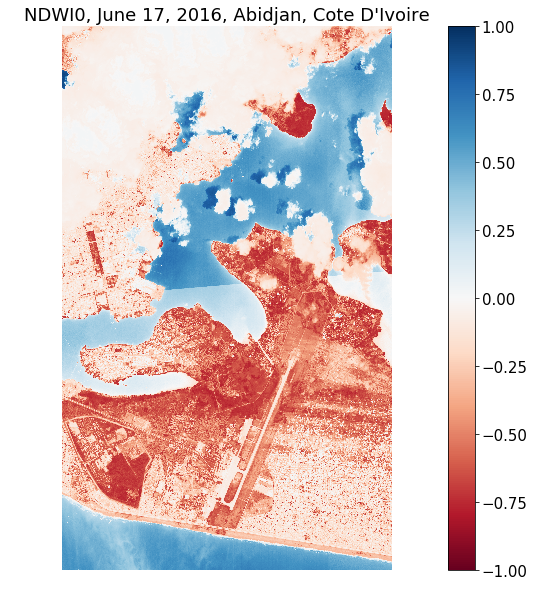

In [18]:
# Plot NDWI0
fig, ax = plt.subplots(figsize=(20,10))
ndwi0_plot = ax.imshow(ndwi0, cmap='RdBu',
                vmin=-1, vmax=1)
fig.colorbar(ndwi0_plot, fraction=.05)
ax.set(title="NDWI0, June 17, 2016, Abidjan, Cote D'Ivoire")
ax.set_axis_off()
plt.show()

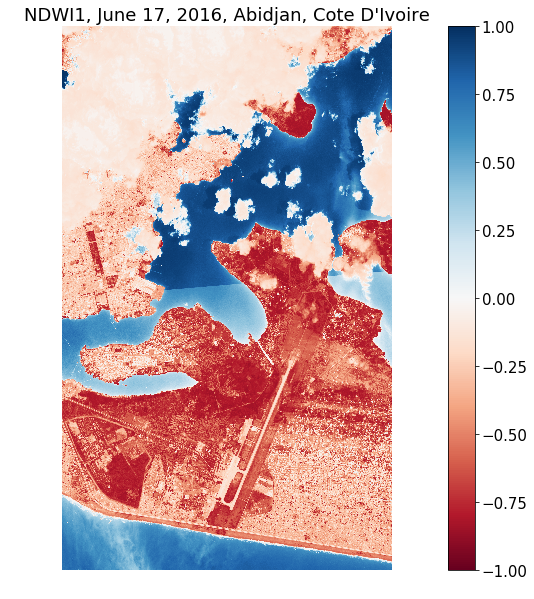

In [19]:
# Plot NDWI1
fig, ax = plt.subplots(figsize=(20,10))
ndwi1_plot = ax.imshow(ndwi1, cmap='RdBu',
                vmin=-1, vmax=1)
fig.colorbar(ndwi1_plot, fraction=.05)
ax.set(title="NDWI1, June 17, 2016, Abidjan, Cote D'Ivoire")
ax.set_axis_off()
plt.show()

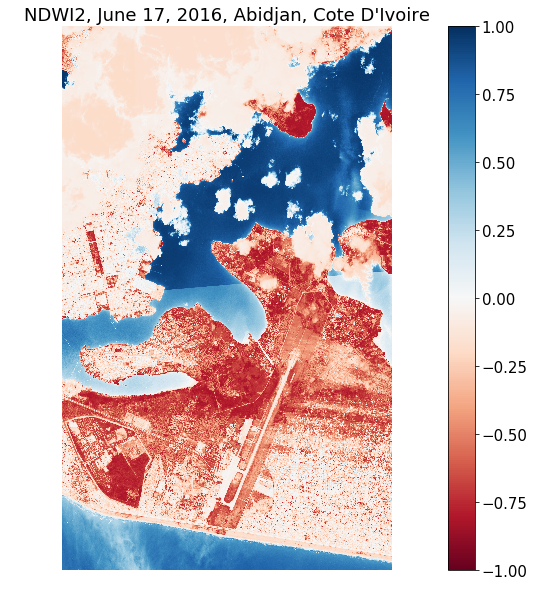

In [20]:
# Plot NDWI2
fig, ax = plt.subplots(figsize=(20,10))
ndwi2_plot = ax.imshow(ndwi2, cmap='RdBu',
                vmin=-1, vmax=1)
fig.colorbar(ndwi2_plot, fraction=.05)
ax.set(title="NDWI2, June 17, 2016, Abidjan, Cote D'Ivoire")
ax.set_axis_off()
plt.show()

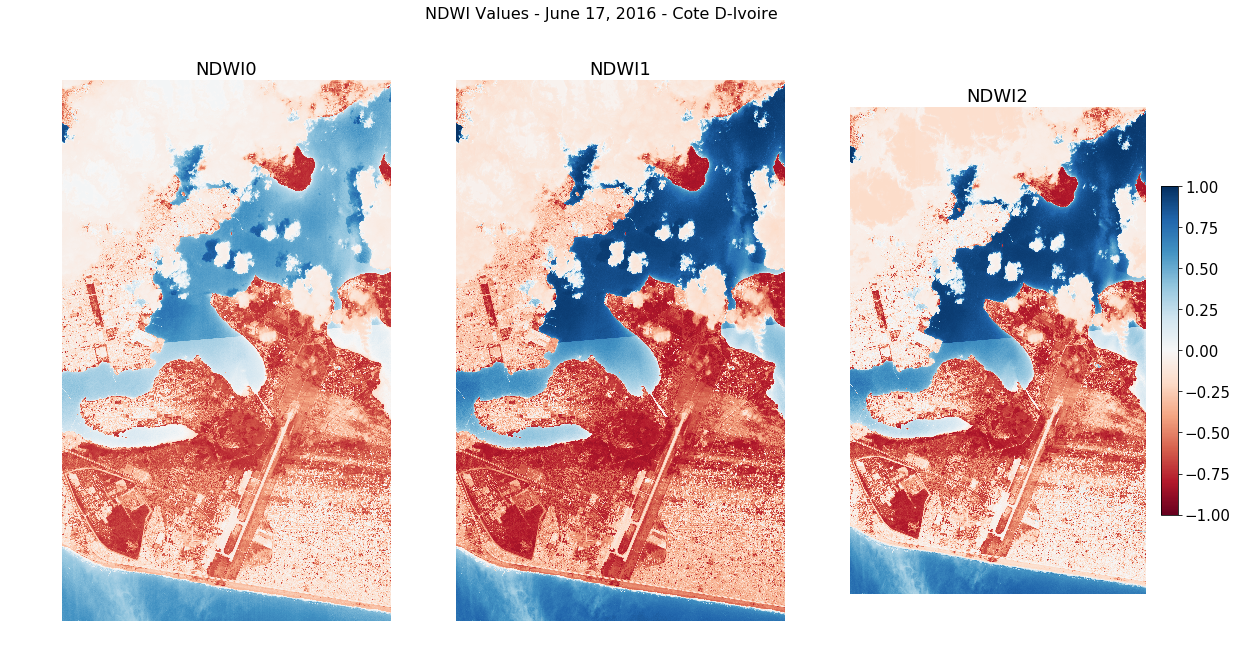

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))

plt.suptitle('NDWI Values - June 17, 2016 - Cote D-Ivoire', fontsize=16)

ndwi0_plot = ax1.imshow(ndwi0, cmap='RdBu',vmin=-1, vmax=1)
fig.colorbar(ndwi0_plot, fraction=.05)
ax1.set(title="NDWI0")
ax1.set_axis_off()

ndwi1_plot = ax2.imshow(ndwi1, cmap='RdBu',vmin=-1, vmax=1)
ax2.set(title="NDWI1")
ax2.set_axis_off()
                        
ndwi2_plot = ax3.imshow(ndwi2, cmap='RdBu',vmin=-1, vmax=1)
ax3.set(title="NDWI2")
ax3.set_axis_off()

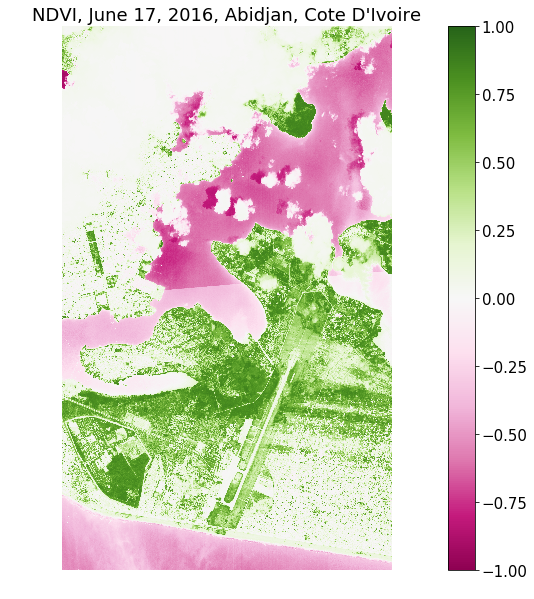

In [24]:
# Plot NDVI
fig, ax = plt.subplots(figsize=(20,10))
ndvi_plot = ax.imshow(ndvi, cmap='PiYG',
                vmin=-1, vmax=1)
fig.colorbar(ndvi_plot, fraction=.05)
ax.set(title="NDVI, June 17, 2016, Abidjan, Cote D'Ivoire")
ax.set_axis_off()
plt.show()

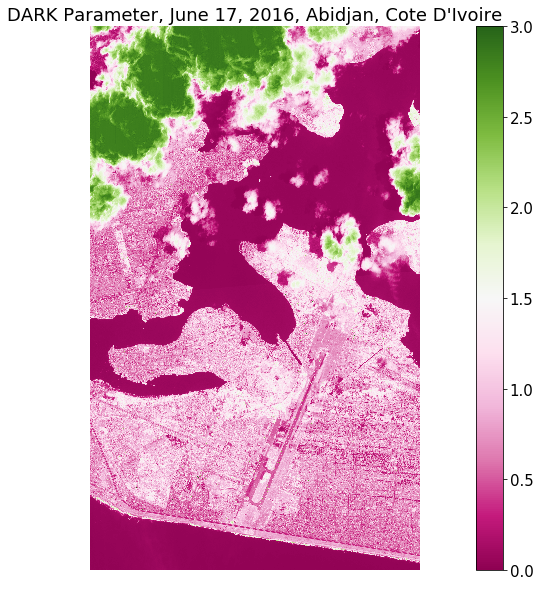

In [32]:
# Plot DARK parameter
fig, ax = plt.subplots(figsize=(20,10))
dark_plot = ax.imshow(dark, cmap='PiYG',
                vmin=0, vmax=3)
fig.colorbar(dark_plot, fraction=.05)
ax.set(title="DARK Parameter, June 17, 2016, Abidjan, Cote D'Ivoire")
ax.set_axis_off()
plt.show()

In [33]:
# Calculate cloud mask layer based on Cloud to Street thresholds
cloud = ((coastal_band >= 0.25) & (rededge_band >= 0.25)).astype(int)

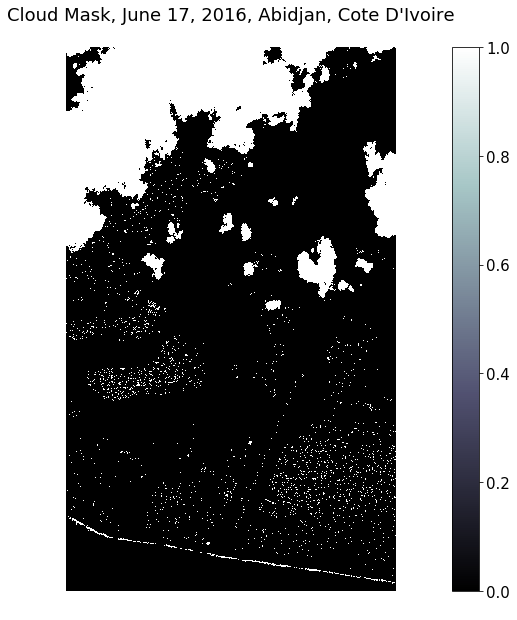

In [34]:
# Plot cloud mask layer 
fig, ax = plt.subplots(figsize=(20,10))
cloud_plot = ax.imshow(cloud, cmap='bone',
                vmin=0, vmax=1)
fig.colorbar(cloud_plot, fraction=.05)
ax.set(title="Cloud Mask, June 17, 2016, Abidjan, Cote D'Ivoire\n")
ax.set_axis_off()
plt.show()

In [35]:
# Calculate flood based on Cloud to Street thresholds
# flood1 = NDWI1 ≥ -0.35, DARK ≤ 5, C ≤ 1, and R ≤ 0.85 
flood1 = ((ndwi1 >= -0.35) & (dark <= 5) & (coastal_band <= 1) & (red_band <= 0.85)).astype(int)

C:\Users\katy\Anaconda3\envs\earth-analytics-python\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater_equal
  This is separate from the ipykernel package so we can avoid doing imports until


In [36]:
# Calcuate food based on Cloud to Street thresholds
# flood2 = NDWI2 ≥ 0.03, DARK ≤ 5.8, C ≤ 1
flood2 = ((ndwi2 >= 0.03) & (dark <= 5.8) & (coastal_band <= 1)).astype(int)

C:\Users\katy\Anaconda3\envs\earth-analytics-python\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater_equal
  This is separate from the ipykernel package so we can avoid doing imports until


#### * Note that "flood" layers include both permanent water and flood. Working on figuring out how to separate. 

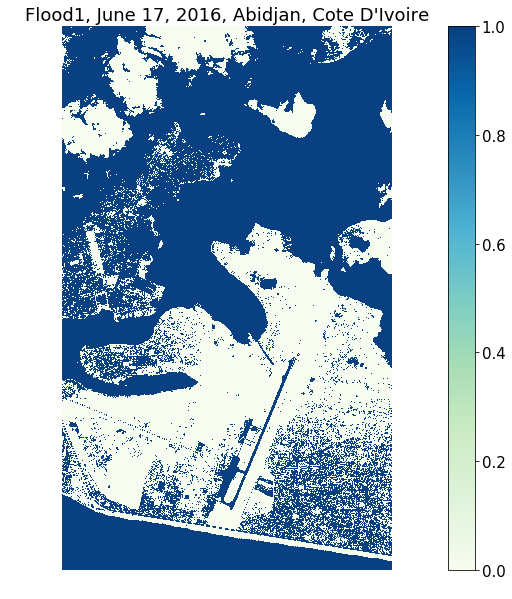

In [37]:
# Plot flood1 mask layer 
fig, ax = plt.subplots(figsize=(20,10))
flood1_plot = ax.imshow(flood1, cmap='GnBu',
                vmin=0, vmax=1)
fig.colorbar(flood1_plot, fraction=.05)
ax.set(title="Flood1, June 17, 2016, Abidjan, Cote D'Ivoire")
ax.set_axis_off()
plt.show()

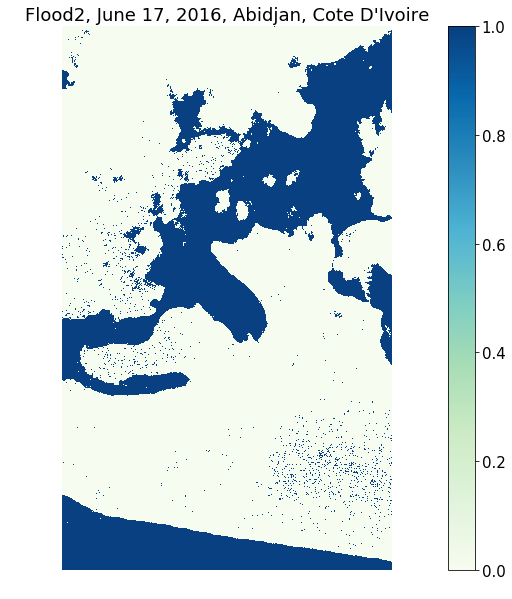

In [38]:
# Plot flood2 mask layer 
fig, ax = plt.subplots(figsize=(20,10))
flood2_plot = ax.imshow(flood2, cmap='GnBu',
                vmin=0, vmax=1)
fig.colorbar(flood2_plot, fraction=.05)
ax.set(title="Flood2, June 17, 2016, Abidjan, Cote D'Ivoire")
ax.set_axis_off()
plt.show()

In [ ]:
#### Need to figure out how to write out NDVI and NDWI values with nan mansked

In [46]:
# Write out tif files for ndwi, ndvi, dark files_out_meta = all_bands_meta 
files_out_meta = all_bands_meta
files_out_meta['count']=1

In [97]:
with rio.open('ndwi0.tif', 'w', **files_out_meta, masked=True) as dst:
    dst.write(ndwi0, 1)

In [48]:
with rio.open('ndwi1.tif', 'w', **files_out_meta) as dst:
    dst.write(ndwi1, 1)

In [49]:
with rio.open('ndwi2.tif', 'w', **files_out_meta) as dst:
    dst.write(ndwi2, 1)

In [59]:
with rio.open('ndvi.tif', 'w', **files_out_meta) as dst:
    dst.write(ndvi, 1)

In [52]:
with rio.open('dark.tif', 'w', **files_out_meta) as dst:
    dst.write(dark, 1)

In [112]:
# Trying to figure out how to keep nan values masked during open
test_path = ('ndwi0.tif')
# Open raster stack
with rio.open(test_path) as src:
    ndwi02 = src.read()  
if np.isinf(ndwi02).any():  
    ndwi02[np.isinf(ndwi02)] = np.nan
if np.isnan(ndwi02).any():
    ndwi02 = np.ma.masked_invalid(ndwi02)
type(ndwi02)

pp.array_equal(ndwi0, ndwi02[0])
# print(ndwi0.max(), ndwi02[0].max())
# np.array_equal(ndwi0, ndwi02[0])